In [1]:
# load data
filepath = "~/datasets/"

In [2]:
# problem 1
cost1 = open(filepath + "p07_c.txt","r")
weights1 = open(filepath + "p07_w.txt", "r")
profits1 = open(filepath + "p07_p.txt", "r")
solution1 = open(filepath + "p07_s.txt", "r")

c1_data = cost1.readlines()
w1_data = weights1.readlines()
p1_data = profits1.readlines()
s1_data = solution1.readlines()
cost1.close()
weights1.close()
profits1.close()
solution1.close()

for i in range(len(c1_data)):
    c1_data[i] = c1_data[i].replace('\n', '')
for i in range(len(w1_data)):
    w1_data[i] = w1_data[i].replace('\n', '')
for i in range(len(p1_data)):
    p1_data[i] = p1_data[i].replace('\n', '')
for i in range(len(s1_data)):
    s1_data[i] = s1_data[i].replace('\n', '')

In [3]:
# problem 2
cost2 = open(filepath + "p08_c.txt","r")
weights2 = open(filepath + "p08_w.txt", "r")
profits2 = open(filepath + "p08_p.txt", "r")
solution2 = open(filepath + "p08_s.txt", "r")

c2_data = cost2.readlines()
w2_data = weights2.readlines()
p2_data = profits2.readlines()
s2_data = solution2.readlines()
cost2.close()
weights2.close()
profits2.close()
solution2.close()

for i in range(len(c2_data)):
    c2_data[i] = c2_data[i].replace('\n', '')
for i in range(len(w2_data)):
    w2_data[i] = w2_data[i].replace('\n', '')
for i in range(len(p2_data)):
    p2_data[i] = p2_data[i].replace('\n', '')
for i in range(len(s2_data)):
    s2_data[i] = s2_data[i].replace('\n', '')

In [4]:
c2_data

['6404180']

In [5]:
import numpy as np
import cvxpy as cp
import time

In [6]:
# regular knapsack implementation
def knapsack(capacity_data, weights_data, profits_data):

    capacity = np.array(capacity_data)
    weights = np.array(weights_data)
    profits = np.array(profits_data)

    # The variable we are solving for
    selection = cp.Variable(len(weights), boolean=True)

    # The sum of the weights should be less than or equal to the capacity
    weight_constraint = weights * selection <= capacity

    # Our total profit is the sum of the item profits
    total_profit = profits * selection

    # Problem definition 
    knapsack_problem = cp.Problem(cp.Maximize(total_profit), [weight_constraint])

    # Solving the problem
    knapsack_problem.solve()

    optimal_profit = total_profit.value
    optimal_selection = selection.value
    #print("Optimal solution:", optimal_profit)
    #print("Optimal set selection:", optimal_selection)
    
    return(optimal_profit, optimal_selection)

In [7]:
### ONE TIME LEARNING ALGORITHM

In [8]:
def dual_partial_knapsack(epsilon, capacity_data, weights_data, profits_data):
    
    # define time s = epsilon x n
    n = len(weights_data)
    s = int(np.floor(epsilon * n))
    
    # subsetting data until time s 
    capacity = int(np.array(capacity_data))
    weights = np.array(weights_data)[0:s]
    profits = np.array(profits_data)[0:s]
    
    ## DUAL PROBLEM

    # The variable we are solving for 
    p = cp.Variable(nonneg = True)
    y = cp.Variable(len(weights), nonneg = True)

    # the dual constraint for every time step t until s
    constraints = []
    for i in range(s):
        constraints += [
            weights[i] * p + y[i] >= profits[i]
        ]

    # dual objective function
    dual_obj = (1 - epsilon) * s/n * capacity * p + cp.sum(y)

    # dual partial knapsack problem 
    dual_partial = cp.Problem(cp.Minimize(dual_obj), constraints)

    # Solving the problem
    dual_partial.solve(solver = cp.GUROBI) # dependence on solver

    optimal_dual = dual_obj.value
    optimal_p = p.value
    optimal_y = y.value

    #print("Optimal dual solution:", optimal_dual)
    #print("Optimal price:", optimal_p)
    #print("Optimal dual vars:", optimal_y)

    return(optimal_p)

In [9]:
def allocation_rule(phi, p, a):
    if phi <= p * a:
        x = 0
    elif phi > p * a:
        x = 1
    return(x)

In [10]:
def existing_weight(weights, x, t):
    prev = 0
    for i in range(t):
        prev += weights[i] * x[i]
    return(prev)  

In [11]:
# Implement One-time learning algorithm (OLA)

def OLA_knapsack(epsilon, capacity_data, weights_data, profits_data):
    
    # define time s = epsilon x n
    n = len(weights_data)
    s = int(np.floor(epsilon * n))
    
    # reading in data 
    capacity = np.array(capacity_data)
    capacity = capacity.astype(np.float)
    weights = np.array(weights_data)
    weights = weights.astype(np.float)
    profits = np.array(profits_data)
    profits = profits.astype(np.float)
    
    start_time = time.time() # record start time
    
    ## OLA steps
    
    # 1. Initialize x_t = 0 for all t <= s, # with phat defined as above
    x = np.empty(n)
    phat = dual_partial_knapsack(epsilon, capacity_data, weights_data, profits_data)
    for i in range(s):
        #if weights[i] * allocation_rule(profits[i], phat, weights[i]) <= (capacity - existing_weight(weights, x, i)):
        #    x[i] = allocation_rule(profits[i], phat, weights[i])
        #else:
        x[i] = 0
    
    # 2. perform updates for 
    for i in range(s,n):
        if weights[i] * allocation_rule(profits[i], phat, weights[i]) <= (capacity - existing_weight(weights, x, i)):
            x[i] = allocation_rule(profits[i], phat, weights[i])
        else:
            x[i] = 0
            
    objective = np.dot(profits, x)
    total_weight = np.dot(weights, x)
    slack = float(capacity - total_weight)
    
    end_time = time.time() # record end time
    run_time = end_time - start_time
            
    return(objective, total_weight, slack, x, run_time)

In [12]:
### DYNAMIC LEARNING ALGORITHM

In [13]:
# Implement Dynamic learning algorithm (DLA)

def DLA_knapsack(epsilon, capacity_data, weights_data, profits_data):
    
    # define time s = epsilon x n
    n = len(weights_data)
    s = int(np.floor(epsilon * n))
    
    # reading in data 
    capacity = np.array(capacity_data)
    capacity = capacity.astype(np.float)
    weights = np.array(weights_data)
    weights = weights.astype(np.float)
    profits = np.array(profits_data)
    profits = profits.astype(np.float)
    
    start_time = time.time() # record start time
    
    ## DLA steps
    
    # 1. Initialize x_t = 0 for all t <= s, # with phat defined as above
    x = np.empty(n)
    phat = dual_partial_knapsack(epsilon, capacity_data, weights_data, profits_data)
    for i in range(s):
        #if weights[i] * allocation_rule(profits[i], phat, weights[i]) <= (capacity - existing_weight(weights, x, i)):
        #    x[i] = allocation_rule(profits[i], phat, weights[i])
        #else:
        x[i] = 0
    r = 1 # initialize r
    l = (2 ** r) * epsilon * n # initialize l 
    h = epsilon * np.sqrt(n/l) # initialize h
    
    # 2. perform updates for 
    for i in range(s,n):
        if i >= l: # once t reaches l, re-solve linear program
            phat = dual_partial_knapsack(h, capacity_data, weights_data, profits_data) # resolve the program
            r += 1 # update r
            l = (2 ** r) * epsilon * n # update l
            h = epsilon * np.sqrt(n/l) # update h
        if weights[i] * allocation_rule(profits[i], phat, weights[i]) <= (capacity - existing_weight(weights, x, i)):
            x[i] = allocation_rule(profits[i], phat, weights[i]) # assign cost.
        else:
            x[i] = 0
            
    objective = np.dot(profits, x)
    total_weight = np.dot(weights, x)
    slack = float(capacity - total_weight)
    
    end_time = time.time() # record end time
    run_time = end_time - start_time
            
    return(objective, total_weight, slack, x, run_time)

In [14]:
### SOLVE FOR EACH PROBLEM

In [15]:
# Test data instances
# solutions from regular knapsack:
pr1, sol1 = knapsack(c1_data, w1_data, p1_data)
pr2, sol2 = knapsack(c2_data, w2_data, p2_data)

Using license file /Users/fietekrutein/gurobi.lic
Academic license - for non-commercial use only


In [16]:
# OLA Results
# Test data 1
epsilon = 0.1
profit, weight, slack, x, runtime = OLA_knapsack(epsilon, c1_data, w1_data, p1_data)
print("Total profit obtained:", profit)
print("Weight of knapsack:", weight)
print("Slack in knapsack:", slack)
print("Optimal selection:", x)
print("Run time:", runtime)

Total profit obtained: 994.0
Weight of knapsack: 507.0
Slack in knapsack: 243.0
Optimal selection: [0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
Run time: 0.024272918701171875


In [17]:
# Test data 2
epsilon = 0.1
profit, weight, slack, x, runtime = OLA_knapsack(epsilon, c2_data, w2_data, p2_data)
print("Total profit obtained:", profit)
print("Weight of knapsack:", weight)
print("Slack in knapsack:", slack)
print("Optimal selection:", x)
print("Run time:", runtime)

Total profit obtained: 6859456.0
Weight of knapsack: 3187471.0
Slack in knapsack: 3216709.0
Optimal selection: [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
Run time: 0.0332331657409668


In [18]:
# DLA Results
# Test data 1
epsilon = 0.1
profit, weight, slack, x, runtime = DLA_knapsack(epsilon, c1_data, w1_data, p1_data)
print("Total profit obtained:", profit)
print("Weight of knapsack:", weight)
print("Slack in knapsack:", slack)
print("Optimal selection:", x)
print("Run time:", runtime)

Total profit obtained: 1377.0
Weight of knapsack: 707.0
Slack in knapsack: 43.0
Optimal selection: [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.]
Run time: 0.08611106872558594


In [19]:
# Test data 2
epsilon = 0.1
profit, weight, slack, x, runtime = DLA_knapsack(epsilon, c2_data, w2_data, p2_data)
print("Total profit obtained:", profit)
print("Weight of knapsack:", weight)
print("Slack in knapsack:", slack)
print("Optimal selection:", x)
print("Run time:", runtime)

Total profit obtained: 6859456.0
Weight of knapsack: 3187471.0
Slack in knapsack: 3216709.0
Optimal selection: [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
Run time: 0.09398078918457031


In [20]:
### EXPERIMENTS ON EPSILON VALUE CHOICE

In [21]:
# let's do it for our data examples

In [22]:
# now run on OLA
total_profits = []
slack_evolve = []
weight_evolve = []
runtimes = []
epsilon_vals = np.linspace(0.32,0.5,50)

for k in epsilon_vals:
    profit, weight, slack, x, runtime = OLA_knapsack(k, c1_data, w1_data, p1_data)
    #print("Epsilon value: ", k)
    #print("Total profit obtained:", profit)
    #print("Weight of knapsack:", weight)
    #print("Slack in knapsack:", slack)
    #print("")
    #print("Optimal selection:", x)
    total_profits.append(profit)
    slack_evolve.append(slack)
    weight_evolve.append(weight)
    runtimes.append(runtime)

OLA_results = np.array((epsilon_vals, np.array(total_profits), np.array(slack_evolve), np.array(weight_evolve), np.array(runtimes)))

In [23]:
# now run on DLA
total_profits = []
slack_evolve = []
weight_evolve = []
runtimes = []
epsilon_vals = np.linspace(0.085,0.5,50)

for k in epsilon_vals:
    profit, weight, slack, x, runtime = DLA_knapsack(k, c1_data, w1_data, p1_data)
    #print("Epsilon value: ", k)
    #print("Total profit obtained:", profit)
    #print("Weight of knapsack:", weight)
    #print("Slack in knapsack:", slack)
    #print("Optimal selection:", x)
    #print("")
    total_profits.append(profit)
    slack_evolve.append(slack)
    weight_evolve.append(weight)
    runtimes.append(runtime)

DLA_results = np.array((epsilon_vals, np.array(total_profits), np.array(slack_evolve), np.array(weight_evolve), np.array(runtimes)))

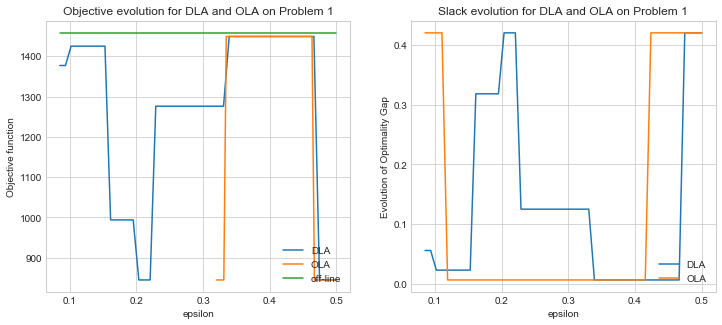

In [24]:
from matplotlib import pyplot as plt

optimal = np.repeat(pr1, DLA_results.shape[1])
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=[12,5])

plot1 = plt.subplot(121)
plt.plot(DLA_results[0], DLA_results[1], label = 'DLA')
plt.plot(OLA_results[0], OLA_results[1], label = 'OLA')
plt.plot(DLA_results[0], optimal, label = 'off-line')
plt.xlabel("epsilon")
plt.ylabel("Objective function")
plt.legend(loc="lower right")
plot1.set_title("Objective evolution for DLA and OLA on Problem 1")

plot2 = plt.subplot(122)
plt.plot(DLA_results[0], 1-(DLA_results[1]/optimal), label = 'DLA')
plt.plot(DLA_results[0], 1-(OLA_results[1]/optimal), label = 'OLA')
plt.xlabel("epsilon")
plt.ylabel("Evolution of Optimality Gap")
plt.legend(loc="lower right")
plot2.set_title("Slack evolution for DLA and OLA on Problem 1")

plt.savefig('Problem 1 epsilon.png', dpi = 800)

plt.show()

In [25]:
# Now lets repeat this for problem 2

In [26]:
# now run on OLA
total_profits = []
slack_evolve = []
weight_evolve = []
runtimes = []
epsilon_vals = np.linspace(0.05,0.5,50)

for k in epsilon_vals:
    profit, weight, slack, x, runtime = OLA_knapsack(k, c2_data, w2_data, p2_data)
    #print("Epsilon value: ", k)
    #print("Total profit obtained:", profit)
    #print("Weight of knapsack:", weight)
    #print("Slack in knapsack:", slack)
    #print("")
    #print("Optimal selection:", x)
    total_profits.append(profit)
    slack_evolve.append(slack)
    weight_evolve.append(weight)
    runtimes.append(runtime)

OLA_results = np.array((epsilon_vals, np.array(total_profits), np.array(slack_evolve), np.array(weight_evolve), np.array(runtimes)))

In [27]:
# now run on DLA
total_profits = []
slack_evolve = []
weight_evolve = []
runtimes = []
epsilon_vals = np.linspace(0.05,0.5,50)

for k in epsilon_vals:
    profit, weight, slack, x, runtime = DLA_knapsack(k, c2_data, w2_data, p2_data)
    #print("Epsilon value: ", k)
    #print("Total profit obtained:", profit)
    #print("Weight of knapsack:", weight)
    #print("Slack in knapsack:", slack)
    #print("Optimal selection:", x)
    #print("")
    total_profits.append(profit)
    slack_evolve.append(slack)
    weight_evolve.append(weight)
    runtimes.append(runtime)

DLA_results = np.array((epsilon_vals, np.array(total_profits), np.array(slack_evolve), np.array(weight_evolve), np.array(runtimes)))

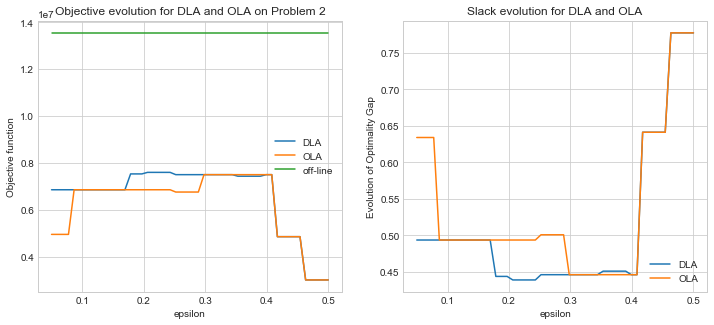

In [28]:
from matplotlib import pyplot as plt

optimal = np.repeat(pr2, DLA_results.shape[1])
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=[12,5])

plot1 = plt.subplot(121)
plt.plot(DLA_results[0], DLA_results[1], label = 'DLA')
plt.plot(OLA_results[0], OLA_results[1], label = 'OLA')
plt.plot(DLA_results[0], optimal, label = 'off-line')
plt.xlabel("epsilon")
plt.ylabel("Objective function")
plt.legend(loc="center right")
plot1.set_title("Objective evolution for DLA and OLA on Problem 2")

plot2 = plt.subplot(122)
plt.plot(DLA_results[0], 1-(DLA_results[1]/optimal), label = 'DLA')
plt.plot(OLA_results[0], 1-(OLA_results[1]/optimal), label = 'OLA')
plt.xlabel("epsilon")
plt.ylabel("Evolution of Optimality Gap")
plt.legend(loc="lower right")
plot2.set_title("Slack evolution for DLA and OLA")

plt.savefig('Problem 2 epsilon.png', dpi = 800)

plt.show()

In [29]:
epsilon_vals = np.linspace(0.01,0.5,50)

In [30]:
# Now, let's generate our own data for a larger instance and test the algorithm on this. 
np.random.seed(123)

test_weights = np.round(np.random.uniform(50,5000, 1000),0)
test_profits = np.round(np.random.uniform(100,20000, 1000),0)
test_capacity = np.floor(np.mean(test_weights)) * 50

In [31]:
test_capacity

126050.0

In [32]:
# lets run it on the optimal knapsack
pr3, sol3 = knapsack(test_capacity, test_weights, test_profits)

In [33]:
# now run on OLA
total_profits = []
slack_evolve = []
weight_evolve = []
runtimes = []
epsilon_vals = np.linspace(0.08,0.5,50)

for k in epsilon_vals:
    profit, weight, slack, x, runtime = OLA_knapsack(k, test_capacity, test_weights, test_profits)
    #print("Epsilon value: ", k)
    #print("Total profit obtained:", profit)
    #print("Weight of knapsack:", weight)
    #print("Slack in knapsack:", slack)
    #print("")
    #print("Optimal selection:", x)
    total_profits.append(profit)
    slack_evolve.append(slack)
    weight_evolve.append(weight)
    runtimes.append(runtime)

OLA_results_S = np.array((epsilon_vals, np.array(total_profits), np.array(slack_evolve), np.array(weight_evolve), np.array(runtimes)))

In [34]:
# now run on DLA
total_profits = []
slack_evolve = []
weight_evolve = []
runtimes = []
epsilon_vals = np.linspace(0.001,0.5,50)

for k in epsilon_vals:
    profit, weight, slack, x, runtime = DLA_knapsack(k, test_capacity, test_weights, test_profits)
    #print("Epsilon value: ", k)
    #print("Total profit obtained:", profit)
    #print("Weight of knapsack:", weight)
    #print("Slack in knapsack:", slack)
    #print("Optimal selection:", x)
    #print("")
    total_profits.append(profit)
    slack_evolve.append(slack)
    weight_evolve.append(weight)
    runtimes.append(runtime)

DLA_results_S = np.array((epsilon_vals, np.array(total_profits), np.array(slack_evolve), np.array(weight_evolve), np.array(runtimes)))

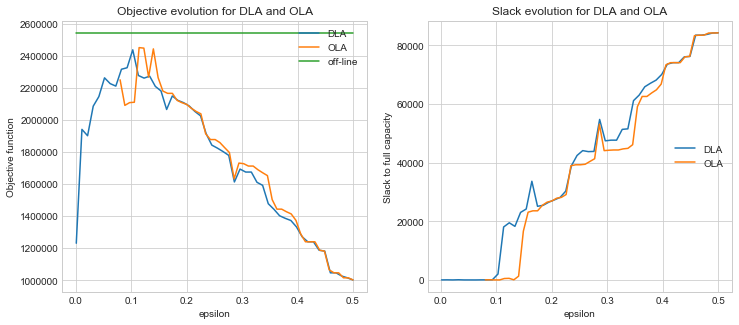

In [35]:
from matplotlib import pyplot as plt

optimal_S = np.repeat(pr3, DLA_results.shape[1])
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=[12,5])

plot1 = plt.subplot(121)
plt.plot(DLA_results_S[0], DLA_results_S[1], label = 'DLA')
plt.plot(OLA_results_S[0], OLA_results_S[1], label = 'OLA')
plt.plot(DLA_results_S[0], optimal_S, label = 'off-line')
plt.xlabel("epsilon")
plt.ylabel("Objective function")
plt.legend(loc="upper right")
plot1.set_title("Objective evolution for DLA and OLA")

plot2 = plt.subplot(122)
plt.plot(DLA_results_S[0], DLA_results_S[2], label = 'DLA')
plt.plot(OLA_results_S[0], OLA_results_S[2], label = 'OLA')
plt.xlabel("epsilon")
plt.ylabel("Slack to full capacity")
plt.legend(loc="center right")
plot2.set_title("Slack evolution for DLA and OLA")

plt.savefig('Problem 3 epsilon.png', dpi = 800)

plt.show()

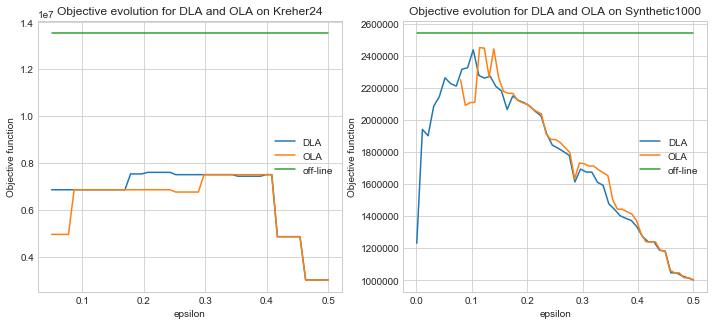

In [36]:
from matplotlib import pyplot as plt

optimal_S = np.repeat(pr3, DLA_results.shape[1])
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=[12,5])

plot1 = plt.subplot(121)
plt.plot(DLA_results[0], DLA_results[1], label = 'DLA')
plt.plot(OLA_results[0], OLA_results[1], label = 'OLA')
plt.plot(DLA_results[0], optimal, label = 'off-line')
plt.xlabel("epsilon")
plt.ylabel("Objective function")
plt.legend(loc="center right")
plot1.set_title("Objective evolution for DLA and OLA on Kreher24")

plot2 = plt.subplot(122)
plt.plot(DLA_results_S[0], DLA_results_S[1], label = 'DLA')
plt.plot(OLA_results_S[0], OLA_results_S[1], label = 'OLA')
plt.plot(DLA_results_S[0], optimal_S, label = 'off-line')
plt.xlabel("epsilon")
plt.ylabel("Objective function")
plt.legend(loc="center right")
plot2.set_title("Objective evolution for DLA and OLA on Synthetic1000")

plt.savefig('Comparison epsilon.png', dpi = 800)

plt.show()

In [37]:
### EXPERIMENTS ON CAPACITY BOUND OF RHS

In [38]:
capacities = np.linspace(np.floor(np.mean(test_weights)), np.floor(np.mean(test_weights)) * 1000, 100)

In [39]:
# now run on OLA
total_profits = []
slack_evolve = []
weight_evolve = []
offline_optimal = []
runtimes = []
epsilon = 0.13

for k in capacities:
    pr, sol = knapsack(k, test_weights, test_profits)
    offline_optimal.append(pr)
    profit, weight, slack, x, runtime = OLA_knapsack(epsilon, k, test_weights, test_profits)
    #print("Knapsack capacity: ", k)
    #print("Total profit obtained:", profit)
    #print("Weight of knapsack:", weight)
    #print("Slack in knapsack:", slack)
    #print("")
    #print("Optimal selection:", x)
    total_profits.append(profit)
    slack_evolve.append(slack)
    weight_evolve.append(weight)
    runtimes.append(runtime)

OLA_results = np.array((capacities, np.array(offline_optimal), np.array(total_profits), np.array(slack_evolve), np.array(weight_evolve), np.array(runtimes)))

In [40]:
# now run on DLA
total_profits = []
slack_evolve = []
weight_evolve = []
offline_optimal = []
runtimes = []
epsilon = 0.1

for k in capacities:
    pr, sol = knapsack(k, test_weights, test_profits)
    offline_optimal.append(pr)
    profit, weight, slack, x, runtime = DLA_knapsack(epsilon, k, test_weights, test_profits)
    #print("Knapsack capacity: ", k)
    #print("Total profit obtained:", profit)
    #print("Weight of knapsack:", weight)
    #print("Slack in knapsack:", slack)
    #print("")
    #print("Optimal selection:", x)
    total_profits.append(profit)
    slack_evolve.append(slack)
    weight_evolve.append(weight)
    runtimes.append(runtime)

DLA_results = np.array((capacities, np.array(offline_optimal), np.array(total_profits), np.array(slack_evolve), np.array(weight_evolve), np.array(runtimes)))

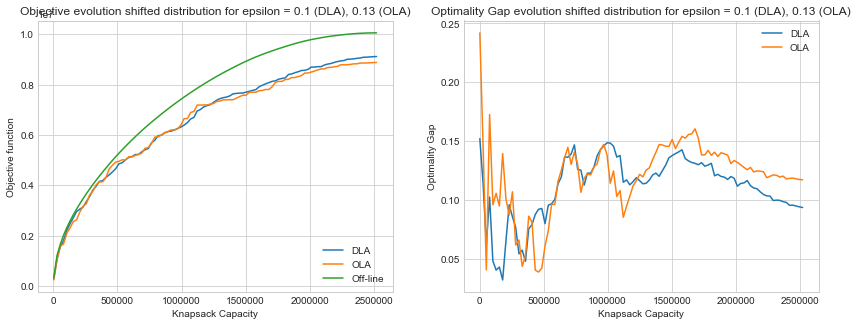

In [41]:
plt.figure(figsize=[14,5])
plt.style.use('seaborn-whitegrid')

plot1 = plt.subplot(121)
plt.plot(DLA_results[0], DLA_results[2], label = 'DLA')
plt.plot(DLA_results[0], OLA_results[2], label = 'OLA')
plt.plot(DLA_results[0], DLA_results[1], label = 'Off-line')
plt.xlabel("Knapsack Capacity")
plt.ylabel("Objective function")
plt.legend(loc="lower right")
plot1.set_title("Objective evolution shifted distribution for epsilon = 0.1 (DLA), 0.13 (OLA)")

plot2 = plt.subplot(122)
plt.plot(DLA_results[0], 1-(DLA_results[2]/DLA_results[1]), label = 'DLA')
plt.plot(DLA_results[0], 1-(OLA_results[2]/OLA_results[1]), label = 'OLA')
plt.xlabel("Knapsack Capacity")
plt.ylabel("Optimality Gap")
plt.legend(loc="upper right")
plot2.set_title("Optimality Gap evolution shifted distribution for epsilon = 0.1 (DLA), 0.13 (OLA)")

#plt.savefig('Problem 3 RHS_diff_epsilon.png', dpi = 800)

plt.show()